In [1]:
import numpy as np
import matplotlib.pyplot as pl
import time
from joblib import Parallel, delayed

In [2]:
c = 3e8
G = 6.67e-11
pi = np.pi
const = 96/5*pi**(8/3)*(G/c**3)**(5/3)

Specific arguments

In [6]:
f0 = 120
Mc = 3e-4* 2e30
f_max = 200
T_obs = 1e4
pad_len = int(323.4*T_obs) #~0.01 added length to resampled data
beta = const*f0**(8/3)*Mc**(5/3)

f_signal = 40*f_max
nt = round(f_signal*T_obs)
t = np.arange(nt)/f_signal
f_ratio = 25

In [7]:
beta

2.7439303219997145e-07

Generating signal and adding noise

In [5]:
phi = -6*pi/5*f0*(1-8./3.*beta*t)**(5/8)/beta
phi = np.mod(phi,2*pi)
signal = 1*np.exp(1j*phi)

nh = 0
noise = nh*np.random.normal(size = nt)
data = signal + noise

In [6]:
# add real Gaussian noise and take real phase
# correct with known exact beta
# with some offsets

In [7]:
%reset_selective -f "^signal$"
%reset_selective -f noise
%reset_selective -f phi

In [8]:
def strobo(beta, data, f_ratio):
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    f_new = f_signal/f_ratio
    
    new_t *= f_new #changes the frequency to the new downsampled frequency (approximately, not exactly)
    floor_t = np.floor(new_t) #For some reason floor works better than round. Take it to the nearest time index which are integers
    idx = np.nonzero(np.diff(floor_t)) #The step that downsamples
    resampled = data[idx]
    t_out = (new_t[idx]-new_t[0])/f_new
    return (resampled, t_out)

In [9]:
f_ratio = 25
out, t_out = strobo(beta, data, f_ratio)
corrected = np.fft.fftshift(np.fft.fft(out))
freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(t_out), d=t_out[1]-t_out[0]))
corrected = corrected[len(corrected)//2:]
resampled_power = np.abs(corrected/len(out))**2

freq_corrected = freq_corrected[len(freq_corrected)//2:]
nt_new = len(out)

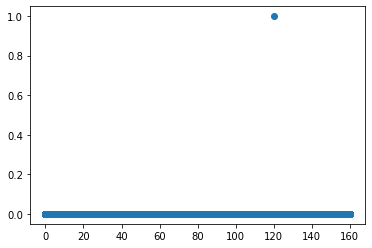

In [10]:
pl.plot(freq_corrected, np.abs(resampled_power), 'o')
# pl.xlim(119.995, 120.005)

In [11]:
len(out)

3200016

In [12]:
(pad_len - len(out)) / pad_len

0.01050834879406308

## Padding the data

In [9]:
def pad_calc(beta, pad_len):
#     print(pad_len)
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    out, t_out = strobo(beta, data, f_ratio)
    pad_frac = (pad_len - len(out)) / len(out)
    padded = np.full(pad_len, 0, dtype = complex)
    padded[:len(out)] = out
    pad_corrected = np.fft.fftshift(np.fft.fft(padded))
    pad_freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(padded), d=t_out[1]-t_out[0]))
    pad_resampled_power = np.abs(pad_corrected/len(padded))**2
    
    arg_max = np.argmax(pad_resampled_power)
    peak_freq = pad_freq_corrected[arg_max]
    peak_power = pad_resampled_power[arg_max]
    return np.array([peak_freq, peak_power, pad_frac])

In [10]:
%reset_selective -f new_t
%reset_selective -f padded
%reset_selective -f phi

In [11]:
tic = time.time()

pad_arr = [int(323.4*T_obs)]
offset_arr = np.logspace(-8, -3, 100)
result_arr = []
padfrac_arr = []

for i in pad_arr:
    temp = np.array(Parallel(4)(delayed(pad_calc)(beta+j*beta, i) for j in offset_arr))
    result_arr.append(temp[:,1]/temp[0,1])
    padfrac_arr.append(100*temp[0,2])

toc = time.time()
print((toc-tic)/60)

2.7140790184338885


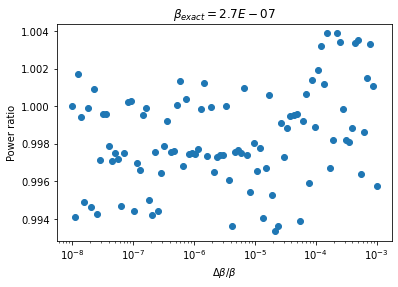

In [14]:
# pl.plot(offset_arr, offset_results[:,0]/ref_freq)
# pl.show()
pl.semilogx(offset_arr, result_arr[0], 'o', 
            label = 'pad_frac=%.1F %%' % padfrac_arr[0])
    
pl.xlabel(r'$\Delta \beta / \beta$')
pl.ylabel('Power ratio')
pl.title(r'$\beta_{exact} = %.1E$' % beta)
# pl.legend()
# pl.axvline(offset_arr[-40])
pl.show()

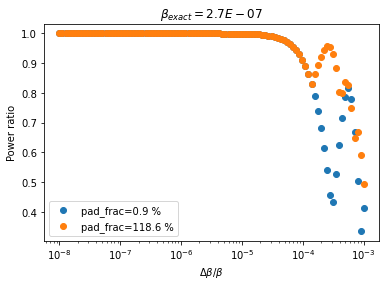

In [19]:
# pl.plot(offset_arr, offset_results[:,0]/ref_freq)
# pl.show()
for i,val in enumerate(result_arr):
    pl.semilogx(offset_arr, val, 'o', 
                label = 'pad_frac=%.1F %%' % padfrac_arr[i])
    
pl.xlabel(r'$\Delta \beta / \beta$')
pl.ylabel('Power ratio')
pl.title(r'$\beta_{exact} = %.1E$' % beta)
pl.legend()
# pl.axvline(offset_arr[-40])
pl.show()

In [28]:
Mc_arr = np.multiply([1e-5, 1e-4, 1e-3],2e30)
f0 = 120
beta_arr = const*f0**(8/3)*np.power(Mc_arr,5/3)

In [29]:
beta_arr

array([9.47336610e-10, 4.39714703e-08, 2.04097486e-06])

In [37]:
Mc_arr = np.multiply([3e-4],2e30)
f0 = 120
beta_arr = const*f0**(8/3)*np.power(Mc_arr,5/3)

offset_arr = np.logspace(-8, -3, 100)
result_arr = []

for i in beta_arr:
    phi = -6*pi/5*f0*(1-8./3.*i*t)**(5/8)/i
    phi = np.mod(phi,2*pi)
    signal = 1*np.exp(1j*phi)
    
    _, ref_power, _ = pad_calc(i, pad_len)
    temp = np.array(Parallel(4)(delayed(pad_calc)(i+j*i, pad_len) for j in offset_arr))
    result_arr.append(temp[:,1]/ref_power)

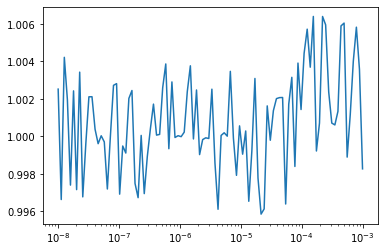

In [38]:
for i, val in enumerate(result_arr):
    pl.semilogx(offset_arr, val)